# Análisis de Abandono de Clientes (Churn Prediction)

## 1. Carga y Exploración de Datos

In [44]:
# Importar librerías
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when, sum
import matplotlib.pyplot as plt
import pandas as pd

# Configuración inicial de Spark
spark = SparkSession.builder \
    .appName("Churn Prediction") \
    .getOrCreate()

# Carga de datos
data = spark.read.csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)
print(f"Dimensiones: {data.count(), len(data.columns)}")
# Primeros 5 registros
display(data.limit(5).toPandas())

Dimensiones: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


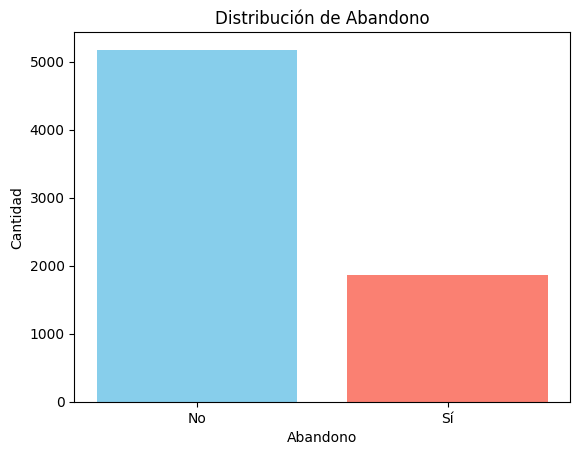

In [45]:
# Distribución de Abandono
dist = data.groupBy('Churn').count().toPandas()
dist['Churn'] = dist['Churn'].replace({'No': 'No', 'Yes': 'Sí'})
plt.bar(dist['Churn'], dist['count'], color=['skyblue', 'salmon'])
plt.title('Distribución de Abandono')
plt.xlabel('Abandono')
plt.ylabel('Cantidad')
plt.show()

## 2. Preprocesamiento

In [46]:
# Eliminar valores nulos en TotalCharges (que fueron leídos como strings)
data = data.withColumn(
    "TotalCharges",
    when(col("TotalCharges") == " ", None).otherwise(col("TotalCharges"))
)
data = data.withColumn("TotalCharges", col("TotalCharges").cast("double"))
data = data.na.drop(subset=["TotalCharges"])

# Eliminar customerID
data = data.drop('customerID')

# Convertir variable objetivo a binaria (0/1)
data = data.withColumn("Churn", when(col("Churn") == "Yes", 1).otherwise(0))

# Convertir variables categóricas a numéricas
cat_cols = [field for (field, dtype) in data.dtypes if dtype == 'string' and field != 'Churn']
for colname in cat_cols:
    indexer = StringIndexer(inputCol=colname, outputCol=colname+"_idx")
    data = indexer.fit(data).transform(data)

# Selección de características
num_cols = [field for (field, dtype) in data.dtypes if dtype in ['double', 'int'] and field != 'Churn']
idx_cols = [c+"_idx" for c in cat_cols]
features = num_cols + idx_cols
assembler = VectorAssembler(inputCols=features, outputCol='features_vec')
data = assembler.transform(data)

# Escalado de características
scaler = StandardScaler(inputCol='features_vec', outputCol='features')
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# División en entrenamiento y prueba
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

## 3. Modelado (Random Forest)

In [47]:
# Crear y entrenar modelo
rf = RandomForestClassifier(labelCol='Churn', featuresCol='features', numTrees=100, seed=42)
rf_model = rf.fit(train_data)
# Hacer predicciones
y_pred = rf_model.transform(test_data)

## 4. Evaluación

In [48]:
# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator_acc.evaluate(y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
pd_pred = y_pred.select('Churn', 'prediction').toPandas()
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(pd_pred['Churn'], pd_pred['prediction']))

Accuracy: 0.7958

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       999
           1       0.68      0.38      0.49       343

    accuracy                           0.80      1342
   macro avg       0.75      0.66      0.68      1342
weighted avg       0.78      0.80      0.77      1342



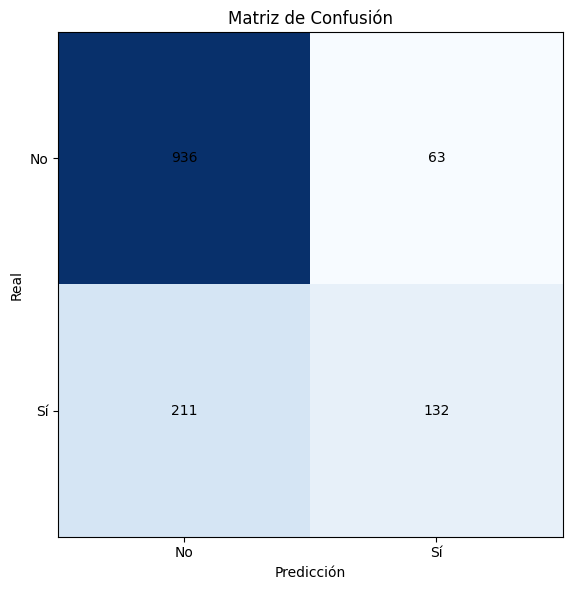

In [49]:
# Matriz de confusión
conf_matrix = confusion_matrix(pd_pred['Churn'], pd_pred['prediction'])
plt.figure(figsize=(6,6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0,1], ['No', 'Sí'])
plt.yticks([0,1], ['No', 'Sí'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

## 5. Visualización de Resultados

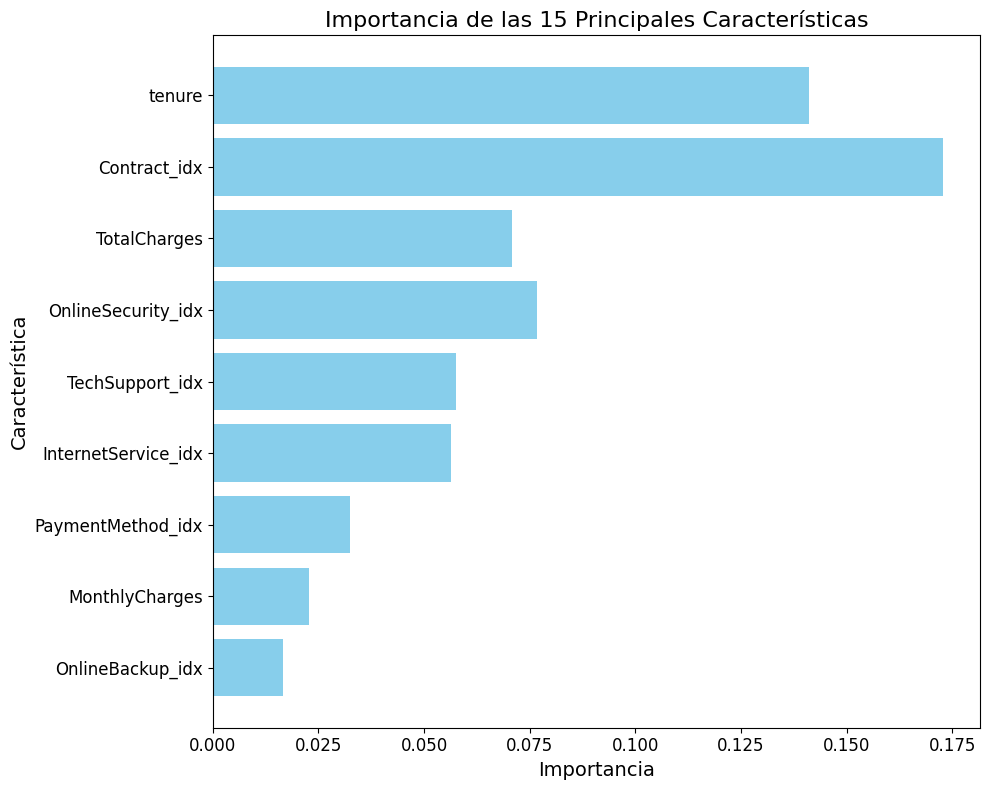

In [50]:
# Importancia de características
importances = rf_model.featureImportances.toArray()
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1], color='skyblue')
plt.title('Importancia de las 15 Principales Características', fontsize=16)
plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Característica', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## 6. Comparación con Otros Modelos

In [51]:
models = [
    ("Random Forest", RandomForestClassifier(labelCol='Churn', featuresCol='features', numTrees=100, seed=42)),
    ("Logistic Regression", LogisticRegression(labelCol='Churn', featuresCol='features', maxIter=100))
]
results = []
for name, model in models:
    m = model.fit(train_data)
    pred = m.transform(test_data)
    acc = evaluator_acc.evaluate(pred)
    results.append({'Model': name, 'Accuracy': acc})
results_df = pd.DataFrame(results)
display(results_df.sort_values('Accuracy', ascending=False))

,Model,Accuracy
1,Logistic Regression,0.807004
0,Random Forest,0.795827


In [52]:
# Detener Spark
spark.stop()